In [3]:
from similarity_searching_sketches.persistence import load_np_array, save_np_array
from similarity_searching_sketches.approx_evaluation import compute_knn_results
from similarity_searching_sketches.approx_evaluation import sort_ids_by_distance
from similarity_searching_sketches.distances import hamming
from similarity_searching_sketches.distances import l1
from similarity_searching_sketches.sketch_producer import MinkowskiSketchProducer
from similarity_searching_sketches.visualization import plot_array
from similarity_searching_sketches.utils import percentage
import numpy as np

In [4]:
DATA_FOLDER='/home/matej/data/sketch-testing/dataset_10K/'
PIVOTS_PATH=DATA_FOLDER+'selected_pivots.npy'
MHI_DB_SAVE_PATH=DATA_FOLDER+'mhi_sketch_db.npy'
TRAIN_SUFFIX='train_set.npy'
TEST_SUFFIX='test_set.npy'
DB_PATH_PREFIX='db_'
QUERY_OBJ_PATH_PREFIX='query_obj_'
KNN_RES_PREFIX='knn_res_'
N_QUERY_OBJS=100
K=100
TESTED_SKETCH_LENGTHS=[2,4,8,16,32,64,128]
FILTERING_SPLITS=10
LOG_BY=5000


#### Generate database and compute k-NN results

In [5]:
def compute_knn(suffix):
    dataset=load_np_array(DATA_FOLDER+suffix)
    np.random.shuffle(dataset)
    queries, dataset=np.split(dataset,[N_QUERY_OBJS])
    ids=np.arange(dataset.shape[0])
    knn_results=compute_knn_results(ids, dataset, queries, K, l1, log_by=LOG_BY)
    save_np_array(DATA_FOLDER+DB_PATH_PREFIX+suffix, dataset)
    save_np_array(DATA_FOLDER+DB_PATH_PREFIX+'ids_'+suffix, ids)
    save_np_array(DATA_FOLDER+QUERY_OBJ_PATH_PREFIX+suffix, queries)
    save_np_array(DATA_FOLDER+KNN_RES_PREFIX+suffix, knn_results)
    return ids,dataset,queries,knn_results
    

In [6]:
ids_train, vecs_train, queries_train, knn_res_train = compute_knn(TRAIN_SUFFIX)
ids_test, vecs_test, queries_test, knn_res_test = compute_knn(TEST_SUFFIX)

INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 14.67520022392273s
 Time from start: 14.675200700759888s


In [7]:
vecs_train.shape

(7900, 4096)

#### Transform database and queries to Sketches

In [8]:
sketch_producer=MinkowskiSketchProducer(pivots_path=PIVOTS_PATH,p=1)

In [9]:
sketches_train=sketch_producer.transform_many(vecs_train)
sketches_queries_train=sketch_producer.transform_many(queries_train)

sketches_test=sketch_producer.transform_many(vecs_test)
sketches_queries_test=sketch_producer.transform_many(queries_test)

In [10]:
sketches_train.shape

(7900, 128)

Save data for MHI experiments

In [15]:
save_np_array(MHI_DB_SAVE_PATH,np.concatenate((sketches_train, sketches_test, sketches_queries_train, sketches_queries_test)))

#### Evaluate approximation quality

In [7]:
def get_sorted_ids(ids, sketches, sketch_queries, sketch_len):
    sketches_shortedned=sketches.T[:sketch_len].T
    sketch_queries_shortened=sketch_queries.T[:sketch_len].T
    return sort_ids_by_distance(ids_train, sketches_shortedned, sketch_queries_shortened, hamming)

sorted_ids_list_train=[]
sorted_ids_list_test=[]

for sketch_len in TESTED_SKETCH_LENGTHS:
    sorted_ids_list_train.append((sketch_len,get_sorted_ids(ids_train, sketches_train,sketches_queries_train, sketch_len)))
    sorted_ids_list_test.append((sketch_len,get_sorted_ids(ids_test, sketches_test,sketches_queries_test, sketch_len)))

INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 0.818397045135498s
 Time from start: 0.8183977603912354s
INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 0.7935378551483154s
 Time from start: 0.7935383319854736s
INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 0.7986540794372559s
 Time from start: 0.7986547946929932s
INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 0.8080539703369141s
 Time from start: 0.8080542087554932s
INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 0.8013980388641357s
 Time from start: 0.8013992309570312s
INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 0.8185722827911377s
 Time from start: 0.818572998046875s
INFO:IterationLogger| Started iteration no.: 5000
 Time from previous iteration: 0.853104829788208s
 Time from start: 0.8531057834625244s


In [19]:
def evaluate_approximation_quality(sorted_ids, true_knn, sketch_len):
    filtering_counts=range(0, sorted_ids.shape[1], int(sorted_ids.shape[1]/FILTERING_SPLITS))
    percentages=[100-int(percentage(cnt, sorted_ids.shape[1])) for cnt in filtering_counts]
    mean_intersection=list()
    for count in filtering_counts:
        intersection_sizes=[]
        for i in range(true_knn.shape[0]):
            intersection_sizes.append(len(set(true_knn[i])&set(sorted_ids[i][:count])))
        mean_intersection.append(np.mean(intersection_sizes))
    plot_array(mean_intersection,xticks=percentages, title='Mean % query result covered in pre-selected (sketch length: '+str(sketch_len)+')', ylabel='Mean % correct in pre-selected', xlabel='% of db filtered ')

#### Approximation quality Train set

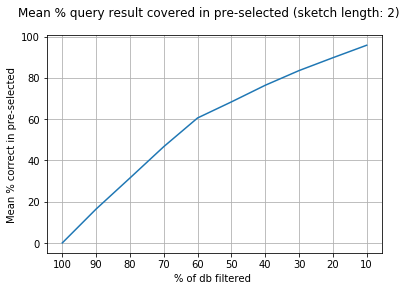

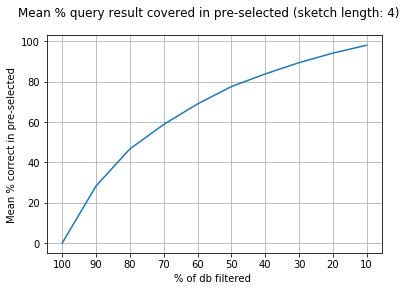

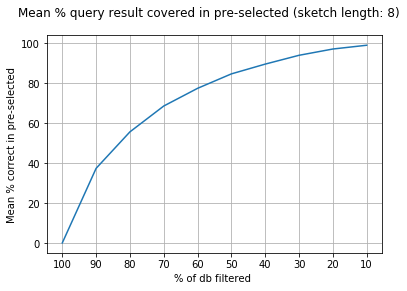

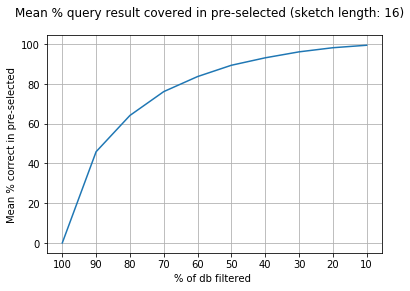

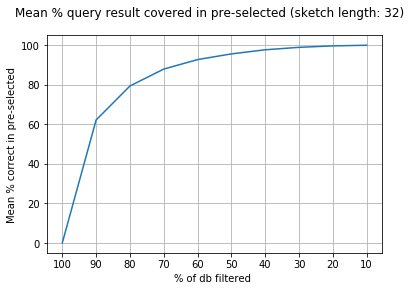

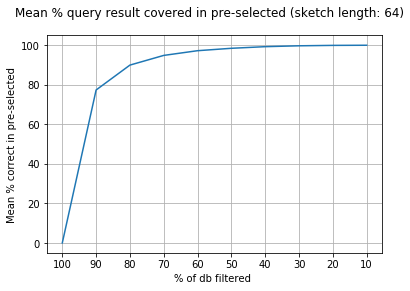

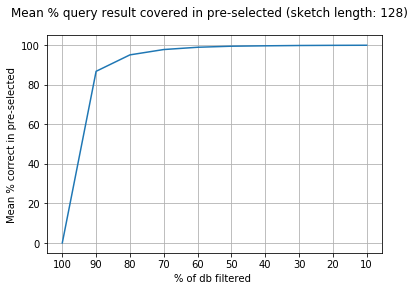

In [20]:
for (sketch_len, sorted_ids) in sorted_ids_list_train:
    evaluate_approximation_quality(sorted_ids, knn_res_train, sketch_len)

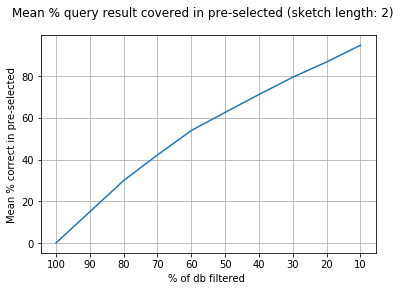

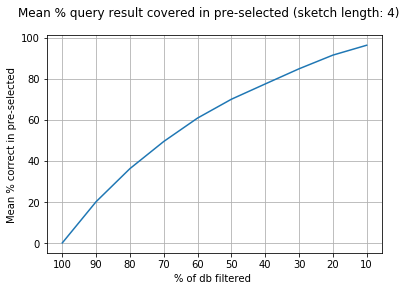

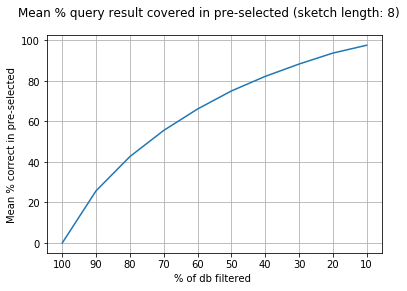

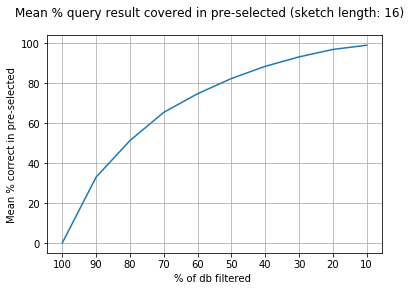

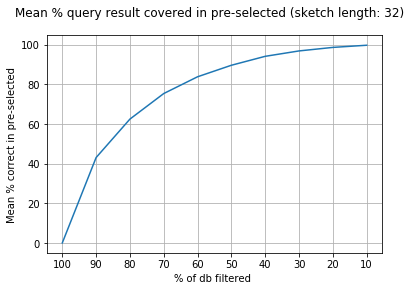

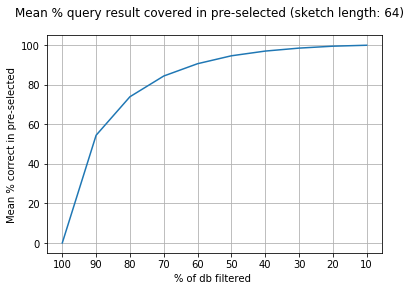

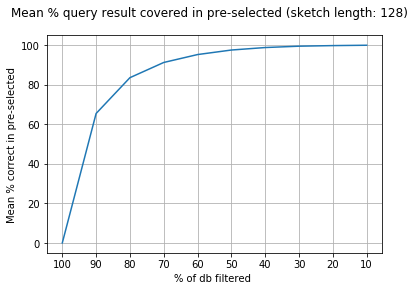

In [21]:
for (sketch_len, sorted_ids) in sorted_ids_list_test:
    evaluate_approximation_quality(sorted_ids, knn_res_test, sketch_len)